# 4장. 분류
# 랜덤 포레스트
+ 배깅 : 같은 알고리즘으로 여러 개의 분류기를 만들어서 보팅으로 최종 결정하는 알고리즘. 배깅의 대표적인 알고리즘은 랜덤 포레스트.
+ 랜덤 포레스트 : 여러 개의 결정 트리 분류기가 전체 데이터에서 배깅 방식으로 각자의 데이터를 샘플링해 개별적으로 학습을 수행한 뒤 최종적으로 모든 분류기가 보팅을 통해 예측을 결정.

+ 부트스트래핑 : 여러 개의 데이터 세트를 "중첩되게" 분리하는 것

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# features.txt 파일에는 피처 이름 index 와 피처명이 공백으로 분리되어 있음. 이를 DataFrame으로 로드.
feature_name_df=pd.read_csv('./human_activity/features.txt', sep='\s+',
                           header=None, names=['column_index', 'column_name'])
    # sep : 한개 이상의 공백문자(\s+)를 기준으로 인덱스와 피쳐 네임을 분리해라 (seperate)
    
# 피처명 index를 제거하고, 피처명만 리스트 객체로 생성한 뒤 샘플로 10개만 추출
feature_name=feature_name_df.iloc[:,1].values.tolist()
print('전체 피처명에서 10개만 추출:', feature_name[:10])

def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                           if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

pd.options.display.max_rows = 999
new_feature_name_df = get_new_feature_name_df(feature_name_df)
new_feature_name_df[new_feature_name_df['dup_cnt'] > 0]

def get_human_dataset( ): # 데이터 로딩과 스플릿
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('./human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 feature명을 새롭게 수정하는 get_new_feature_name_df()를 이용하여 새로운 feature명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./human_activity/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('./human_activity/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('./human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('./human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test


전체 피처명에서 10개만 추출: ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import warnings 
warnings.filterwarnings('ignore')

# 결정 트리에서 사용한 get_human_dataset()을 이용해 학습/테스트용 DataFrame 반환
X_train, X_test, y_train, y_test = get_human_dataset()

# 랜덤 포레스트 학습 및 별도의 테스트 세트로 예측 성능 평가
rf_clf=RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train) # 학습
pred=rf_clf.predict(X_test) # 예측
accuracy=accuracy_score(y_test, pred) # 정확도 평가
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도: 0.9108


## 랜덤 포레스트 하이퍼 파라미터 및 튜닝

+ n_estimators : 랜덤 포레스트에서 결정 트리의 개수를 지정. 디폴트는 10개. 많이 설정할수록 좋은 성능을 기대할 수 있지만 계속 증가시킨다고 성능이 무조건 향상되는건 아님.
+ max_features : 결정 트리에 사용된 max_features 파라미터와 같지만, 랜덤포레스트의 기본 max_features는 sqrt를 자동으로 씌움. 따라서 랜덤 포레스트의 트리를 분할하는 피처를 참조할 때 전체 피처가 아니라 sqrt(전체 피처 개수)만큼 참조한다. (전체 피처가 16개라면 분할을 위해 4개 참조)

#### GridSearchCV를 이용해 랜덤 포레스트의 하이퍼 파라미터 튜닝하기.

In [6]:
from sklearn.model_selection import GridSearchCV

params={
    'n_estimators':[300],
    'max_depth':[6,8,10,12],
    'min_samples_leaf':[8,12,18],
    'min_samples_split':[8,16,20]
}

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf=RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv=GridSearchCV(rf_clf, param_grid=params, cv=5, n_jobs=-1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 12, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 300}
최고 예측 정확도: 0.9261


#### => 결과로 나온 최적의 하이퍼 파라미터로 다시 돌려보기.

In [9]:
rf_clf1=RandomForestClassifier(n_estimators=300, max_depth=12, min_samples_leaf=8,
                               min_samples_split=8, random_state=0)
rf_clf1.fit(X_train, y_train)
pred=rf_clf1.predict(X_test)
print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))

예측 정확도: 0.9199


#### 랜덤포레스트도 의사결정나무처럼 feature_importances_ 속성으로 알고리즘이 선택한 피처의 중요도를 알 수 있음. 막대그래프로 시각화해보기.

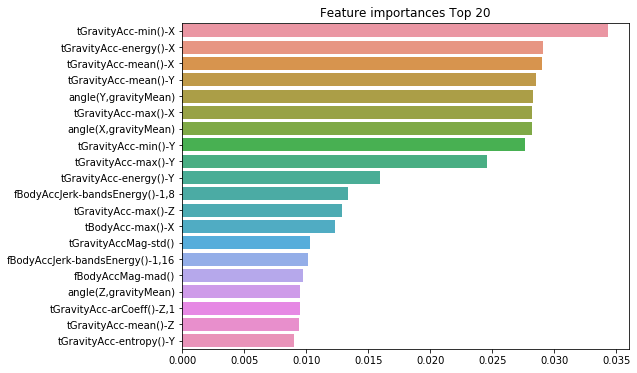

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values=rf_clf1.feature_importances_
ftr_importances=pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20=ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

# heart 데이터로 랜덤포레스트 돌려보기

In [15]:
heart_data=pd.read_csv('/Users/air/Leena Python/MachineLearning/heart.csv')

In [13]:
heart_data.head(3)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1


In [26]:
heart_feature=heart_data.drop(['target'], axis=1)
heart_label=heart_data['target']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(heart_feature, heart_label, 
                                                    test_size=0.2, random_state=0)

In [28]:
# 랜덤 포레스트 학습 및 별도의 테스트 세트로 예측 성능 평가
rf_clf=RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train) # 학습
pred=rf_clf.predict(X_test) # 예측
accuracy=accuracy_score(y_test, pred) # 정확도 평가
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도: 0.8852


In [32]:
from sklearn.model_selection import GridSearchCV

params={
    'n_estimators':[100],
    'max_depth':[6,8,10,12],
    'min_samples_leaf':[8,12,18],
    'min_samples_split':[8,16,20]
}

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf=RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv=GridSearchCV(rf_clf, param_grid=params, cv=5, n_jobs=-1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 20, 'n_estimators': 100}
최고 예측 정확도: 0.8306


In [33]:
rf_clf1=RandomForestClassifier(n_estimators=100, max_depth=6, min_samples_leaf=8,
                               min_samples_split=20, random_state=0)
rf_clf1.fit(X_train, y_train)
pred=rf_clf1.predict(X_test)
print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))

예측 정확도: 0.8525


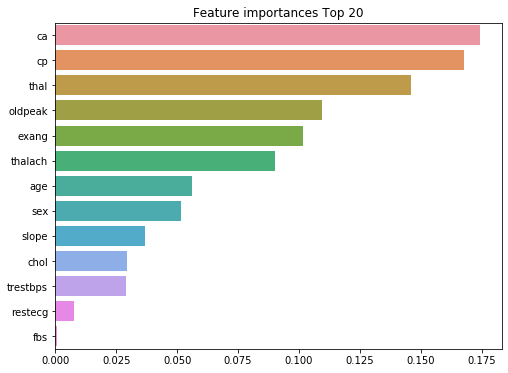

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values=rf_clf1.feature_importances_
ftr_importances=pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20=ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

# 에이다 부스트
#### : 간단한 약분류기들이 상호보완하도록 단계적(순차적)으로 학습. 이들을 조합하여 최종 강분류기의 성능을 증폭시킨다.
#### : 약분류기들을 한 번에 하나씩 순차적으로 학습시킬 때, 먼저 학습된 분류기가 잘못 분류한 결과 정보를 다음 분류기의 학습 시 사용하여 이전 분류기의 단점을 보완하도록 한다.
#### : 즉, 이전 분류기가 오분류한 샘플의 가중치를 adaptive하게 바꿔가며 잘못 분류되는 데이터에 더 집중하여 잘 학습하고 분류할 수 있도록 한다.
#### 최종 분류기는 개별 약분류기들에 각각 가중치를 적용, 조합하여 얻을 수 있다.
+ 장점 : 오류률이 낮고 코드가 쉬움. 가장 좋은 분류기를 가지고 분류하며, 매개변수가 없음
+ 단점 : 에이다 부스트는 분류정밀도가 높지만 학습 데이터의 노이즈에 쉽게 영향을 받음.
+ 활용 : 수치형, 명목형 값

+ Ensemble method : Predict class label of previously unseen records by aggregating predictions made by multiple classifiers. => 다수의 classifier들을 조합하여 최종 예측 성능을 향상시킴.
+ Boosting : An iterative procedure to adaptively change distribution of training data by focusing more on previously mis-classified records. => Parallel한 과정이 아니라 Sequential한 과정.

In [1]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import tree, ensemble
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
# 손으로 쓴 숫자 데이터 읽기
digits=datasets.load_digits()
print(digits)
print(digits.target)
# digits에 임의의 숫자들이 픽셀형태로 저장되있음. 예를들어 1은 [0,0,0,1,0,0,0,10, ...]
# 1부터 15까지의 숫자가 배열형태로 각 숫자마다 표현되있는데, 15로 갈수록 색이 진한 것.

{'data': array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]]), 'target': array([0, 1, 2, ..., 8, 9, 8]), 'target_names': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), 'images': array([[[ 0.,  0.,  5., ...,  1.,  0.,  0.],
        [ 0.,  0., 13., ..., 15.,  5.,  0.],
        [ 0.,  3., 15., ..., 11.,  8.,  0.],
        ...,
        [ 0.,  4., 11., ..., 12.,  7.,  0.],
        [ 0.,  2., 14., ..., 12.,  0.,  0.],
        [ 0.,  0.,  6., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  5.,  0.,  0.],
        [ 0.,  0.,  0., ...,  9.,  0.,  0.],
        [ 0.,  0.,  3., ...,  6.,  0.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., 12.,  0

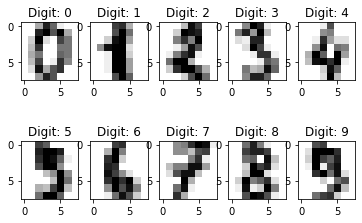

In [8]:
# 이미지를 2행 5열로 표시
for label, img in zip(digits.target[:10], digits.images[:10]):
    # digits.target은 label로써, 실제 1,2,3 숫자 값이 들어가있음.
    # 손글씨 데이터인 images와 target의 픽셀값을 비교하여 예측
    plt.subplot(2, 5,label+1) # 이미지를 2행 5열의 형태로 출력한다.
    plt.axis('on') # 이미지 픽셀 눈금자를 추가하려면 on, 빼려면 off
    plt.imshow(img, cmap=plt.cm.gray_r, interpolation='nearest') # 이미지를 손글씨로
    plt.title('Digit: {0}'.format(label)) # 이미지의 타이틀을 라벨, 타겟으로 해서 보여주기
plt.show()


In [18]:
# 3과 8의 데이터 위치를 구하기
print(digits.target==3) # target값이 3일때만 True, 아닐땐 False 저장
flag_3_8 = (digits.target==3)+(digits.target==8) # 우리는 3과 8만 볼거기 때문에 타겟값이 3과 8일때의 인덱스만 저장
print(flag_3_8)
# 3과 8의 데이터를 구하기
images=digits.images[flag_3_8] # 3과 8일때의 인덱스 위치의 손글씨만 저장
labels=digits.target[flag_3_8] # 3과 8일때의 인덱스 위치의 타겟값만 저장
print(images)
print(labels)

[False False False ... False False False]
[False False False ...  True False  True]
[[[ 0.  0.  7. ...  1.  0.  0.]
  [ 0.  8. 13. ...  4.  0.  0.]
  [ 0.  2.  1. ...  0.  0.  0.]
  ...
  [ 0.  0.  0. ... 10.  8.  0.]
  [ 0.  0.  8. ... 14.  9.  0.]
  [ 0.  0.  7. ...  9.  0.  0.]]

 [[ 0.  0.  9. ...  1.  0.  0.]
  [ 0.  0. 12. ... 12.  0.  0.]
  [ 0.  0.  9. ... 15.  4.  0.]
  ...
  [ 0.  3. 16. ... 13.  2.  0.]
  [ 0.  1. 15. ... 16.  8.  0.]
  [ 0.  0. 11. ... 11.  1.  0.]]

 [[ 0.  2.  9. ...  9.  3.  0.]
  [ 0.  4. 13. ... 16.  8.  0.]
  [ 0.  0.  0. ... 15.  3.  0.]
  ...
  [ 0.  0.  0. ... 15.  4.  0.]
  [ 0.  1.  5. ... 16.  6.  0.]
  [ 0.  2. 12. ... 11.  0.  0.]]

 ...

 [[ 0.  0.  5. ...  0.  1.  0.]
  [ 0.  0. 11. ... 13.  6.  0.]
  [ 0.  0.  2. ... 12.  1.  0.]
  ...
  [ 0.  0.  8. ... 11.  0.  0.]
  [ 0.  0. 11. ...  9.  0.  0.]
  [ 0.  0.  6. ...  3.  0.  0.]]

 [[ 0.  0.  1. ...  1.  0.  0.]
  [ 0.  0. 13. ...  2.  1.  0.]
  [ 0.  0. 16. ... 16.  5.  0.]
  ...
  [ 0.  

In [22]:
# 3과 8의 이미지 데이터를 1차원화
images=images.reshape(images.shape[0],-1) # 열을 행에 따라 변하도록 가변행화.
print(images)
# 분류기 생성
n_samples=len(flag_3_8[flag_3_8])
print(n_samples) # = 357개
train_size=int(n_samples*3/5)
print(train_size) # = 전체 357개 중 학습할 214개(3/5)라는 개수를 저장 (int)
classifier=ensemble.AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(max_depth=3),
                                                                                n_estimators=50)
classifier.fit(images[:train_size], labels[:train_size])

[[ 0.  0.  7. ...  9.  0.  0.]
 [ 0.  0.  9. ... 11.  1.  0.]
 [ 0.  2.  9. ... 11.  0.  0.]
 ...
 [ 0.  0.  5. ...  3.  0.  0.]
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]
357
214


AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                             

In [24]:
# 분류기 성능을 확인
expected=labels[train_size:] # 실제 레이블 값
print(expected)
predicted=classifier.predict(images[train_size:]) # 예측값
print(predicted)
# 몇개는 3을 8로, 8을 3으로 예측한것을 알 수 있음.

print('Accuracy:\n', accuracy_score(expected, predicted))
print('Confusion matrix:\n', confusion_matrix(expected, predicted))
    # TN = 66, TP = 68. positive가 3이므로 8을 8로 예측할 경우가 66, 3을 3으로 예측할 경우가 68.
print('Precision:\n', precision_score(expected, predicted, pos_label=3))
    # pos_label=positive로 설정할 레이블 값
print('Recall:\n', recall_score(expected, predicted, pos_label=3))
print('F-measure:\n', f1_score(expected, predicted, pos_label=3))

[3 8 3 3 3 3 8 3 3 3 8 3 3 8 8 8 8 8 3 8 3 8 3 8 8 8 3 8 3 3 3 3 8 3 3 3 8
 3 3 8 8 8 8 8 3 8 3 8 3 8 8 8 3 8 3 3 3 3 8 3 3 3 8 3 3 8 8 8 8 3 8 3 8 3
 8 8 8 3 8 3 3 3 3 8 3 3 3 8 3 3 8 8 8 8 8 3 8 3 3 8 8 8 3 8 3 3 3 3 8 3 3
 3 8 3 3 8 8 3 8 3 8 3 8 8 8 3 8 3 3 3 3 8 3 3 3 8 3 3 8 8 8 8 8]
[3 8 3 3 3 3 8 3 3 3 8 3 3 8 8 8 8 8 3 8 3 8 3 8 8 8 8 8 3 3 3 3 8 3 3 3 8
 3 3 8 8 8 8 8 3 8 3 8 3 8 8 8 3 8 3 3 3 3 8 3 3 3 8 3 3 8 8 8 8 3 8 3 8 3
 8 8 8 3 8 3 3 3 3 8 3 3 3 8 3 3 8 8 8 8 8 3 8 3 3 8 8 8 3 8 8 3 3 3 8 3 3
 3 8 3 3 8 8 3 8 8 8 8 8 8 8 8 8 8 8 3 8 8 3 3 3 8 8 3 8 8 8 8 8]
Accuracy:
 0.9370629370629371
Confusion matrix:
 [[66  9]
 [ 0 68]]
Precision:
 1.0
Recall:
 0.88
F-measure:
 0.9361702127659575
